In [1]:
import os
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

In [36]:
TPATH = '/home/arnavw/Code/ml/GAJSHIELD_KJSCE/model/data/image_data/malware_dataset/train'
VPATH = '/home/arnavw/Code/ml/GAJSHIELD_KJSCE/model/data/image_data/malware_dataset/val'

In [37]:
# Define transformations for grayscale images
transform = transforms.Compose([
    transforms.Resize((64, 64)),  # Resize to fixed size
    transforms.Grayscale(num_output_channels=1),  # Convert to grayscale
    transforms.ToTensor(),  # Convert to tensor
    transforms.Normalize(mean=[0.5], std=[0.5])  # Normalize
])

# Use ImageFolder to load the dataset
train_dataset = datasets.ImageFolder(root=TPATH, transform=transform)
val_dataset = datasets.ImageFolder(root=VPATH, transform=transform)

# Create DataLoader
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

In [12]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
from torchsummary import summary

In [23]:
class FeatureExtractorCNN(nn.Module):
    def __init__(self):
        super(FeatureExtractorCNN, self).__init__()
        self.model = nn.Sequential(
            # Block 1
            nn.Conv2d(in_channels=1, out_channels=64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.GELU(),
            nn.MaxPool2d(kernel_size=2, stride=2),  # Output: (Batch, 64, 32, 32)
            
            # Block 2
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.GELU(),
            nn.Dropout(0.2),
            nn.MaxPool2d(kernel_size=2, stride=2),  # Output: (Batch, 64, 16, 16)
            
            # Block 3
            nn.Conv2d(in_channels=64, out_channels=32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.GELU(),
            nn.Dropout(0.3),
            nn.MaxPool2d(kernel_size=2, stride=2),  # Output: (Batch, 32, 8, 8)
            
            # Flatten
            nn.Flatten(),
            
            # Fully Connected Layer
            nn.Linear(32 * 8 * 8, 256),  # Adjust based on input size
            nn.LeakyReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, 128),  # Final feature vector size
            nn.ReLU()
        )
    
    def forward(self, x):
        return self.model(x)


In [24]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
feature_extractor = FeatureExtractorCNN().to(device)
summary(feature_extractor, (1, 64, 64))  # Input shape is (batch_size, channels, height * width)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 64, 64]             640
       BatchNorm2d-2           [-1, 64, 64, 64]             128
              GELU-3           [-1, 64, 64, 64]               0
         MaxPool2d-4           [-1, 64, 32, 32]               0
            Conv2d-5           [-1, 64, 32, 32]          36,928
       BatchNorm2d-6           [-1, 64, 32, 32]             128
              GELU-7           [-1, 64, 32, 32]               0
           Dropout-8           [-1, 64, 32, 32]               0
         MaxPool2d-9           [-1, 64, 16, 16]               0
           Conv2d-10           [-1, 32, 16, 16]          18,464
      BatchNorm2d-11           [-1, 32, 16, 16]              64
             GELU-12           [-1, 32, 16, 16]               0
          Dropout-13           [-1, 32, 16, 16]               0
        MaxPool2d-14             [-1, 3

In [25]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(feature_extractor.parameters(), lr=0.001)
scheduler = StepLR(optimizer, step_size=5, gamma=0.1)  # Reduce LR by 10x every 5 epochs

# Training loop
def train_model(model, dataloader, criterion, optimizer, scheduler, num_epochs=25):
    model.train()
    for epoch in range(num_epochs):
        running_loss = 0.0
        correct = 0
        total = 0
        
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            
            # Zero the parameter gradients
            optimizer.zero_grad()
            
            # Forward pass
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)
            
            # Backward pass and optimize
            loss.backward()
            optimizer.step()
            
            # Statistics
            running_loss += loss.item()
            total += labels.size(0)
            correct += (preds == labels).sum().item()
        
        # Update learning rate
        scheduler.step()
        
        epoch_loss = running_loss / len(dataloader)
        epoch_acc = correct / total
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.4f}")

# Train the CNN
train_model(feature_extractor, train_loader, criterion, optimizer, scheduler, num_epochs=25)

Epoch [1/25], Loss: 2.1834, Accuracy: 0.5446
Epoch [2/25], Loss: 1.0435, Accuracy: 0.7698
Epoch [3/25], Loss: 0.6030, Accuracy: 0.8561
Epoch [4/25], Loss: 0.5321, Accuracy: 0.8691
Epoch [5/25], Loss: 0.4445, Accuracy: 0.8916
Epoch [6/25], Loss: 0.2307, Accuracy: 0.9349
Epoch [7/25], Loss: 0.1888, Accuracy: 0.9489
Epoch [8/25], Loss: 0.1783, Accuracy: 0.9487
Epoch [9/25], Loss: 0.1683, Accuracy: 0.9548
Epoch [10/25], Loss: 0.1551, Accuracy: 0.9587
Epoch [11/25], Loss: 0.1487, Accuracy: 0.9598
Epoch [12/25], Loss: 0.1471, Accuracy: 0.9593
Epoch [13/25], Loss: 0.1445, Accuracy: 0.9587
Epoch [14/25], Loss: 0.1474, Accuracy: 0.9593
Epoch [15/25], Loss: 0.1415, Accuracy: 0.9623
Epoch [16/25], Loss: 0.1392, Accuracy: 0.9624
Epoch [17/25], Loss: 0.1433, Accuracy: 0.9605
Epoch [18/25], Loss: 0.1411, Accuracy: 0.9611
Epoch [19/25], Loss: 0.1443, Accuracy: 0.9586
Epoch [20/25], Loss: 0.1394, Accuracy: 0.9604
Epoch [21/25], Loss: 0.1395, Accuracy: 0.9624
Epoch [22/25], Loss: 0.1392, Accuracy: 0.96

In [26]:
for param in feature_extractor.parameters():
    param.requires_grad = False

In [28]:
import numpy as np

In [33]:
torch.save(feature_extractor.state_dict(), 'feature_extractor.pth')
# Load the model

In [38]:
def extract_features(dataloader, model):
    model.eval()  # Set model to evaluation mode
    features = []
    labels = []
    with torch.no_grad():
        for images, targets in dataloader:
            images, targets = images.to(device), targets.to(device)
            outputs = model(images)
            features.append(outputs.cpu().numpy())
            labels.append(targets.cpu().numpy())
    return np.vstack(features), np.hstack(labels)

# Extract features from the dataset
val_features, val_labels = extract_features(val_loader, feature_extractor)

In [40]:
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier

In [41]:
# Split into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(val_features, val_labels, test_size=0.2, random_state=42)

# Train XGBoost classifier
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
xgb_model.fit(X_train, y_train)

# Evaluate the model
val_predictions = xgb_model.predict(X_val)
accuracy = np.mean(val_predictions == y_val)
print(f"Validation Accuracy: {accuracy:.4f}")

/home/arnavw/Code/ml/GAJSHIELD_KJSCE/model/venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [21:24:04] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Validation Accuracy: 0.9381


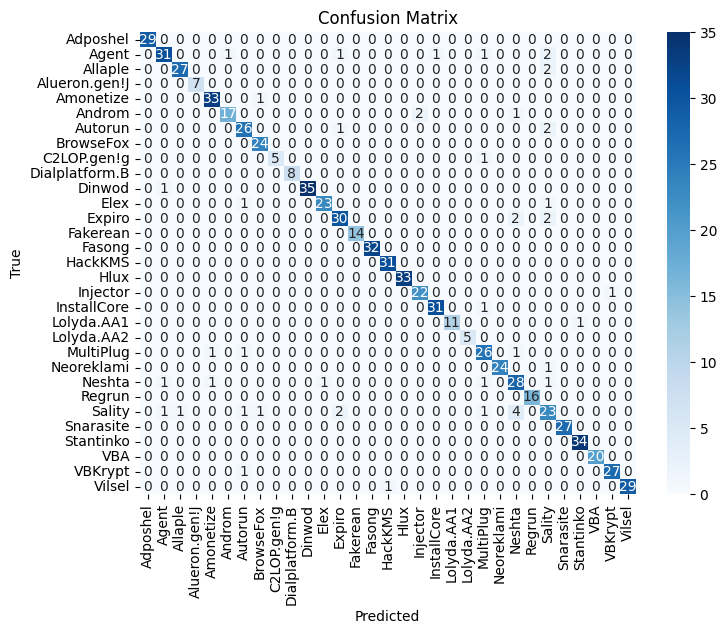

In [42]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Generate confusion matrix
cm = confusion_matrix(y_val, val_predictions)

# Plot confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=train_dataset.classes, yticklabels=train_dataset.classes)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

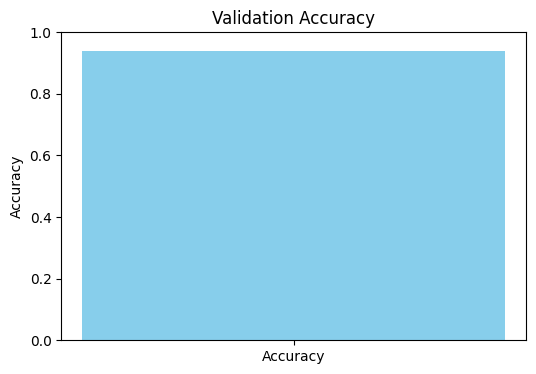

In [43]:
from sklearn.metrics import accuracy_score

# Calculate accuracy
accuracy = accuracy_score(y_val, val_predictions)

# Plot accuracy
plt.figure(figsize=(6, 4))
plt.bar(['Accuracy'], [accuracy], color='skyblue')
plt.ylim(0, 1)
plt.title('Validation Accuracy')
plt.ylabel('Accuracy')
plt.show()

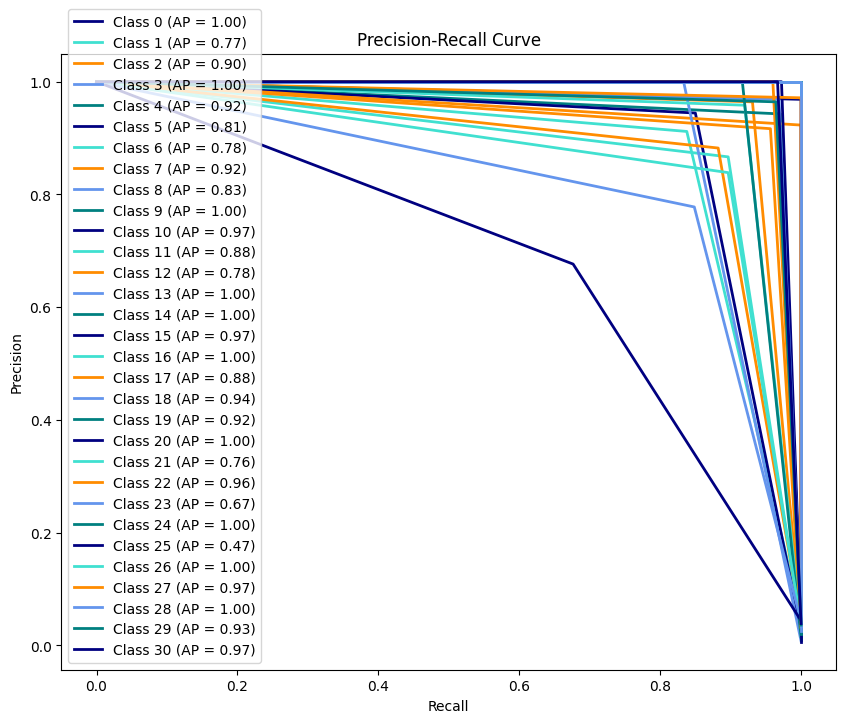

In [44]:
from sklearn.metrics import precision_recall_curve, average_precision_score
from sklearn.preprocessing import label_binarize
from itertools import cycle

# Binarize the labels for multi-class classification
y_val_bin = label_binarize(y_val, classes=range(len(train_dataset.classes)))
val_pred_bin = label_binarize(val_predictions, classes=range(len(train_dataset.classes)))

# Compute precision-recall pairs for each class
precision = dict()
recall = dict()
average_precision = dict()
n_classes = len(train_dataset.classes)

for i in range(n_classes):
    precision[i], recall[i], _ = precision_recall_curve(y_val_bin[:, i], val_pred_bin[:, i])
    average_precision[i] = average_precision_score(y_val_bin[:, i], val_pred_bin[:, i])

# Plot precision-recall curve for each class
plt.figure(figsize=(10, 8))
colors = cycle(['navy', 'turquoise', 'darkorange', 'cornflowerblue', 'teal'])
for i, color in zip(range(n_classes), colors):
    plt.plot(recall[i], precision[i], color=color, lw=2,
             label=f'Class {i} (AP = {average_precision[i]:.2f})')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="lower left")
plt.show()

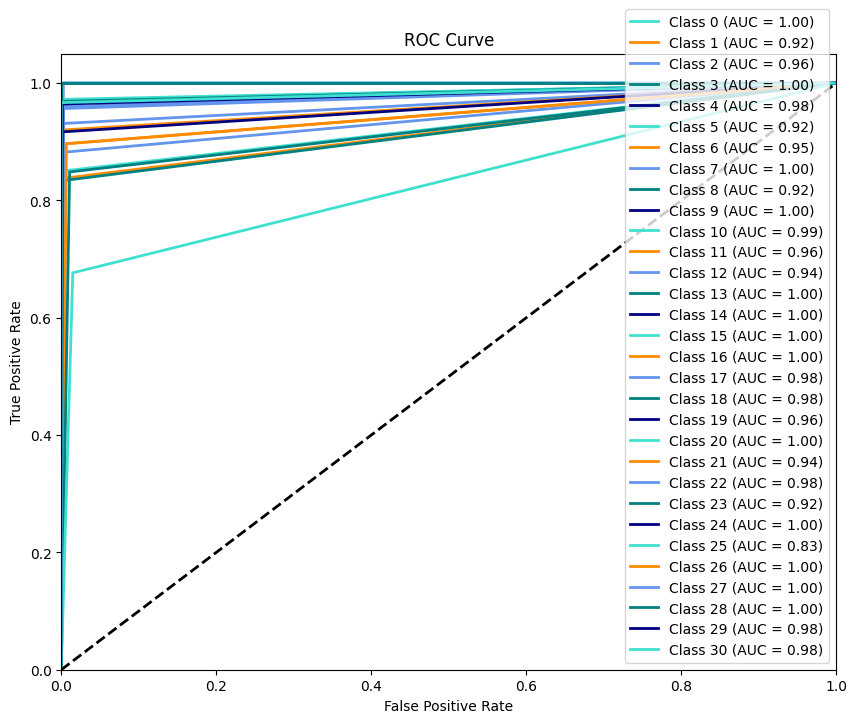

In [45]:
from sklearn.metrics import roc_curve, auc

# Compute ROC curve and AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_val_bin[:, i], val_pred_bin[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curve for each class
plt.figure(figsize=(10, 8))
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'Class {i} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)  # Diagonal line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

In [46]:
import math
from PIL import Image
import numpy as np

def exe_to_image(exe_path, output_path):
    # Read the executable file in binary mode
    with open(exe_path, 'rb') as f:
        byte_data = f.read()
    
    # Calculate dimensions for a square-ish image
    data_len = len(byte_data)
    width = math.ceil(math.sqrt(data_len))
    height = width
    
    # Create a numpy array and pad with zeros if needed
    img_array = np.zeros((height, width), dtype=np.uint8)
    np_data = np.frombuffer(byte_data, dtype=np.uint8)
    img_array.flat[:len(np_data)] = np_data
    
    # Create and save the image
    img = Image.fromarray(img_array, mode='L')
    img.save(output_path)
    print(f"Image saved to {output_path} (Dimensions: {width}x{height})")

# Usage example
exe_to_image('JaffaCakes118_b23c693ab0321b30bf3272efb39ef280.exe', 'test_bytecode_image.png')

Image saved to test_bytecode_image.png (Dimensions: 535x535)


In [48]:
def preprocess_image(image_path):
    image = Image.open(image_path).convert('RGB')  # Ensure RGB format
    image = transform(image)  # Apply transformations
    image = image.unsqueeze(0)  # Add batch dimension (Batch, Channels, Height, Width)
    return image

# Example usage
image_path = 'test_bytecode_image.png'
input_image = preprocess_image(image_path)

In [49]:
def extract_features_single_image(model, image):
    model.eval()  # Set model to evaluation mode
    with torch.no_grad():
        image = image.to(device)  # Move image to the same device as the model
        features = model(image)  # Extract features
        features = features.cpu().numpy()  # Move features back to CPU for XGBoost
    return features

# Extract features
features = extract_features_single_image(feature_extractor, input_image)

In [ ]:
# Predict using the trained XGBoost model
def predict_with_xgboost(xgb_model, features):
    prediction = xgb_model.predict(features)  # Get the predicted class
    return prediction

# Make prediction
predicted_class = predict_with_xgboost(xgb_model, features)
print(f"Predicted Class: {predicted_class[0]}")

AttributeError: 'XGBClassifier' object has no attribute 'predictProba'

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam
# from torchmetrics import Accuracy, AUROC, Precision, Recall


# 5.1 First branch: Deep CNN for sequential pattern recognition
class CNNBranch(nn.Module):
    def _init_(self, input_shape):
        super(CNNBranch, self)._init_()
        # Residual block 1
        self.conv1 = nn.Conv1d(input_shape[0], 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm1d(32)
        self.conv2 = nn.Conv1d(32, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm1d(64)
        self.pool1 = nn.MaxPool1d(kernel_size=2)
        self.dropout1 = nn.Dropout(0.35)
        
        # Residual block 2
        self.conv3 = nn.Conv1d(64, 64, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm1d(64)
        self.conv4 = nn.Conv1d(64, 128, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm1d(128)
        self.proj1 = nn.Conv1d(64, 128, kernel_size=1, padding=0)
        self.pool2 = nn.MaxPool1d(kernel_size=2)
        self.dropout2 = nn.Dropout(0.4)
        
        # Residual block 3
        self.conv5 = nn.Conv1d(128, 256, kernel_size=3, padding=1)
        self.bn5 = nn.BatchNorm1d(256)
        self.conv6 = nn.Conv1d(256, 256, kernel_size=3, padding=1)
        self.bn6 = nn.BatchNorm1d(256)
        self.proj2 = nn.Conv1d(128, 256, kernel_size=1, padding=0)
        self.pool3 = nn.MaxPool1d(kernel_size=2)
        self.dropout3 = nn.Dropout(0.4)
        
        # Global pooling
        self.gap = nn.AdaptiveAvgPool1d(1)
        
    def forward(self, x):
        # Input shape should be [batch, channels, sequence_length]
        # Transpose if input is [batch, sequence_length, channels]
        if x.shape[1] != self.conv1.in_channels:
            x = x.transpose(1, 2)
            
        # Residual block 1
        identity = x
        x1 = self.conv1(x)
        x1 = F.leaky_relu(x1, negative_slope=0.01)
        x1 = self.bn1(x1)
        x1 = self.conv2(x1)
        x1 = self.bn2(x1)
        
        # Adjust identity dimensions for residual connection if needed
        if identity.shape[1] != x1.shape[1]:
            identity = F.pad(identity, (0, 0, 0, x1.shape[1] - identity.shape[1]))
            
        x1 = x1 + identity
        x1 = F.gelu(x1)
        x1 = self.pool1(x1)
        x1 = self.dropout1(x1)
        
        # Residual block 2
        identity = x1
        x2 = self.conv3(x1)
        x2 = F.leaky_relu(x2, negative_slope=0.01)
        x2 = self.bn3(x2)
        x2 = self.conv4(x2)
        x2 = self.bn4(x2)
        
        # Projection for residual connection
        identity = self.proj1(identity)
        
        x2 = x2 + identity
        x2 = F.gelu(x2)
        x2 = self.pool2(x2)
        x2 = self.dropout2(x2)
        
        # Residual block 3
        identity = x2
        x3 = self.conv5(x2)
        x3 = F.leaky_relu(x3, negative_slope=0.01)
        x3 = self.bn5(x3)
        x3 = self.conv6(x3)
        x3 = self.bn6(x3)
        
        # Projection for residual connection
        identity = self.proj2(identity)
        
        x3 = x3 + identity
        x3 = F.gelu(x3)
        x3 = self.pool3(x3)
        x3 = self.dropout3(x3)
        
        # Global pooling
        x3 = self.gap(x3)
        x3 = x3.view(x3.size(0), -1)  # Flatten
        
        return x3


# 5.2 Second branch: Bidirectional RNN for sequence relationships
class RNNBranch(nn.Module):
    def _init_(self, input_shape):
        super(RNNBranch, self)._init_()
        
        # First Bidirectional GRU layer
        self.gru1 = nn.GRU(input_shape[1], 128, batch_first=True, bidirectional=True)
        self.bn1 = nn.BatchNorm1d(256)  # 256 = 128*2 (bidirectional)
        self.dropout1 = nn.Dropout(0.3)
        
        # Second Bidirectional GRU layer
        self.gru2 = nn.GRU(256, 64, batch_first=True, bidirectional=True)
        self.bn2 = nn.BatchNorm1d(128)  # 128 = 64*2 (bidirectional)
        self.dropout2 = nn.Dropout(0.3)
        
    def forward(self, x):
        # Input shape should be [batch, sequence_length, features]
        
        # First Bidirectional GRU layer
        x, _ = self.gru1(x)
        # Apply batch normalization after reshaping
        x = self.bn1(x.transpose(1, 2).contiguous().view(x.size(0), 256, -1)).view(x.size(0), -1, 256).transpose(1, 2)
        x = self.dropout1(x)
        
        # Second Bidirectional GRU layer
        x, _ = self.gru2(x)
        # For the last GRU, we only need the last output
        x = x[:, -1, :]
        x = self.bn2(x)
        x = self.dropout2(x)
        
        return x


# 5.3 Third branch: Dense network for engineered features
class EngineeredFeaturesBranch(nn.Module):
    def _init_(self, input_shape):
        super(EngineeredFeaturesBranch, self)._init_()
        
        self.dense1 = nn.Linear(input_shape, 256)
        self.bn1 = nn.BatchNorm1d(256)
        self.dropout1 = nn.Dropout(0.5)
        
        self.dense2 = nn.Linear(256, 128)
        self.bn2 = nn.BatchNorm1d(128)
        self.dropout2 = nn.Dropout(0.4)
        
    def forward(self, x):
        x = self.dense1(x)
        x = F.relu(x)
        x = self.bn1(x)
        x = self.dropout1(x)
        
        x = self.dense2(x)
        x = F.relu(x)
        x = self.bn2(x)
        x = self.dropout2(x)
        
        return x


# 5.4 Combine all branches
class HybridModel(nn.Module):
    def _init_(self, sequence_shape, engineered_features_shape):
        super(HybridModel, self)._init_()
        
        self.cnn_branch = CNNBranch(sequence_shape)
        self.rnn_branch = RNNBranch(sequence_shape)
        self.feat_branch = EngineeredFeaturesBranch(engineered_features_shape)
        
        # Calculate the size of concatenated output
        # CNN output: 256
        # RNN output: 128
        # Engineered features output: 128
        merged_size = 256 + 128 + 128
        
        # Final dense layers
        self.dense1 = nn.Linear(merged_size, 256)
        self.bn1 = nn.BatchNorm1d(256)
        self.dropout1 = nn.Dropout(0.5)
        
        self.dense2 = nn.Linear(256, 128)
        self.bn2 = nn.BatchNorm1d(128)
        self.dropout2 = nn.Dropout(0.5)
        
        # Output layer
        self.output = nn.Linear(128, 1)
        
    def forward(self, cnn_input, rnn_input, feat_input):
        cnn_output = self.cnn_branch(cnn_input)
        rnn_output = self.rnn_branch(rnn_input)
        feat_output = self.feat_branch(feat_input)
        
        # Concatenate all branches
        merged = torch.cat([cnn_output, rnn_output, feat_output], dim=1)
        
        # Final dense layers
        x = self.dense1(merged)
        x = F.relu(x)
        x = self.bn1(x)
        x = self.dropout1(x)
        
        x = self.dense2(x)
        x = F.relu(x)
        x = self.bn2(x)
        x = self.dropout2(x)
        
        # Output layer
        x = self.output(x)
        x = torch.sigmoid(x)
        
        return x


# Training function
def train_hybrid_model(model, train_loader, val_loader, num_epochs=10):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    
    # Define loss function and optimizer
    criterion = nn.BCELoss()
    optimizer = Adam(model.parameters(), lr=0.001)
    
    # Define metrics
    accuracy = Accuracy(task="binary").to(device)
    auc = AUROC(task="binary").to(device)
    precision = Precision(task="binary").to(device)
    recall = Recall(task="binary").to(device)
    
    for epoch in range(num_epochs):
        # Training phase
        model.train()
        train_loss = 0.0
        
        for cnn_batch, rnn_batch, feat_batch, labels in train_loader:
            cnn_batch, rnn_batch, feat_batch, labels = (
                cnn_batch.to(device),
                rnn_batch.to(device),
                feat_batch.to(device),
                labels.to(device)
            )
            
            # Forward pass
            outputs = model(cnn_batch, rnn_batch, feat_batch)
            loss = criterion(outputs, labels)
            
            # Backward pass and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
        
        # Validation phase
        model.eval()
        val_loss = 0.0
        all_preds = []
        all_labels = []
        
        with torch.no_grad():
            for cnn_batch, rnn_batch, feat_batch, labels in val_loader:
                cnn_batch, rnn_batch, feat_batch, labels = (
                    cnn_batch.to(device),
                    rnn_batch.to(device),
                    feat_batch.to(device),
                    labels.to(device)
                )
                
                outputs = model(cnn_batch, rnn_batch, feat_batch)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                
                all_preds.append(outputs)
                all_labels.append(labels)
            
            # Concatenate all predictions and labels
            all_preds = torch.cat(all_preds)
            all_labels = torch.cat(all_labels)
            
            # Calculate metrics
            acc = accuracy(all_preds, all_labels)
            auc_score = auc(all_preds, all_labels)
            prec = precision(all_preds, all_labels)
            rec = recall(all_preds, all_labels)
        
        print(f"Epoch {epoch+1}/{num_epochs}")
        print(f"Train Loss: {train_loss/len(train_loader):.4f}")
        print(f"Val Loss: {val_loss/len(val_loader):.4f}")
        print(f"Accuracy: {acc:.4f}, AUC: {auc_score:.4f}")
        print(f"Precision: {prec:.4f}, Recall: {rec:.4f}")
        
    return model


# Example usage
def create_hybrid_model(sequence_shape, engineered_features_shape):
    model = HybridModel(sequence_shape, engineered_features_shape)
    return model

ModuleNotFoundError: No module named 'torchmetrics'